Initial Explore of Malaysia data
====

Let's just see what's there

Prerequisites
----
 - map the RDSF network drive to Z:\
 - python with the right packages installed

In [1]:
import pandas as pd

# First let's look at eating time from the smartwatches
path = r"Z:\SEACO data\SEACO-CH20_Smartwatch_data\New_files\combine_csv_file.csv"

df = pd.read_csv(path)

In [2]:
""" Clean the data to only contains meals - I don't know what some of the others mean """
import numpy as np

allowed_meal_types = ("Snack", "Drink", "Meal", "No food/drink")
keep_mask = df["meal_type"].isin(allowed_meal_types)


def count_dict(array: pd.Series) -> dict:
    """Return a dict of unique values + counts in an array"""
    return dict(zip(*np.unique(array, return_counts=True)))

print(f"Discarding: {count_dict(df[~keep_mask].meal_type)}")

df = df[keep_mask]
print(f"Kept: {count_dict(df.meal_type)}")

Discarding: {'Catch-up end': 84, 'Catch-up start': 110, 'No catch-up': 474, 'No response': 3533}
Kept: {'Drink': 1484, 'Meal': 1663, 'No food/drink': 2641, 'Snack': 550}


In [3]:
""" Find the times where these meals were eaten """
import datetime

dates = df["date"]
times = df["timestamp"]


def timestamp(date: str, time: str) -> float:
    """
    Convert a date and time to datetime

    """
    assert len(date) == 9
    assert len(time) == 8

    # Convert to a datetime object
    return datetime.datetime.strptime(date + time, r"%d%b%Y%H:%M:%S").timestamp()


timestamps = np.array([timestamp(date, time) for date, time in zip(dates, times)])

In [4]:
""" Get the eating events for this user """
meal_types = df["meal_type"]
meal_sizes = df["portion_size"]
meal_utensils = df["utensil"]

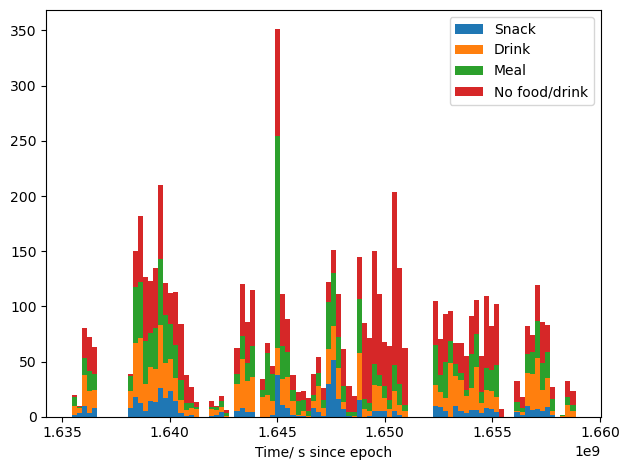

In [5]:
""" Make a cumulative histogram showing each type of meal """
import matplotlib.pyplot as plt
%config InlineBackend.close_figures=False

def format_plot(fig: plt.Figure, axes: plt.Axes) -> None:
    """ Axis labels etc """
    axes.set_xlabel("Time/ s since epoch")
    fig.tight_layout()


fig, axes = plt.subplots()
bins = np.linspace(np.min(timestamps), np.max(timestamps), 100)

axes.hist([timestamps[meal_types == meal] for meal in allowed_meal_types],
           bins=bins,
           label= allowed_meal_types,
           stacked=True,)
axes.legend()
format_plot(fig, axes)


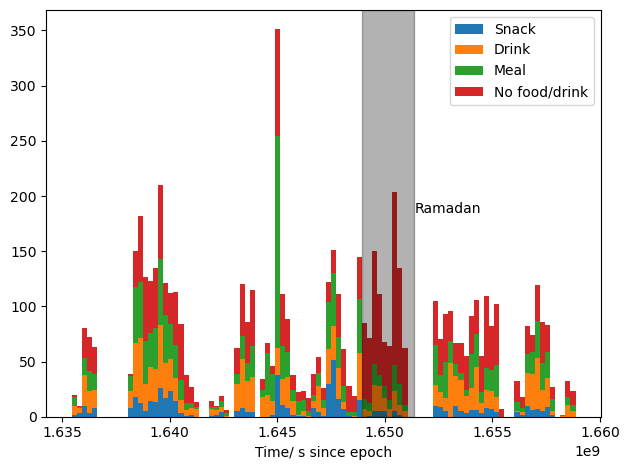

In [6]:
""" Label the start/end of Ramadan """
# This also checks that there's only one unique start/end of ramadan
(ramadan_start,) = np.unique(df["ramadanstart"])
(ramadan_end,) = np.unique(df["ramadanend"])

null_time = "00:00:00"
start_timestamp = timestamp(ramadan_start, null_time)
end_timestamp = timestamp(ramadan_end, null_time)

ylim = axes.get_ylim()
axes.fill_betweenx(
    ylim, [start_timestamp] * 2, [end_timestamp] * 2, alpha=0.3, color="k"
)
axes.set_ylim(ylim)
axes.text(end_timestamp + 10000, (ylim[0] + ylim[1]) / 2, "Ramadan", color="k")

plt.show()

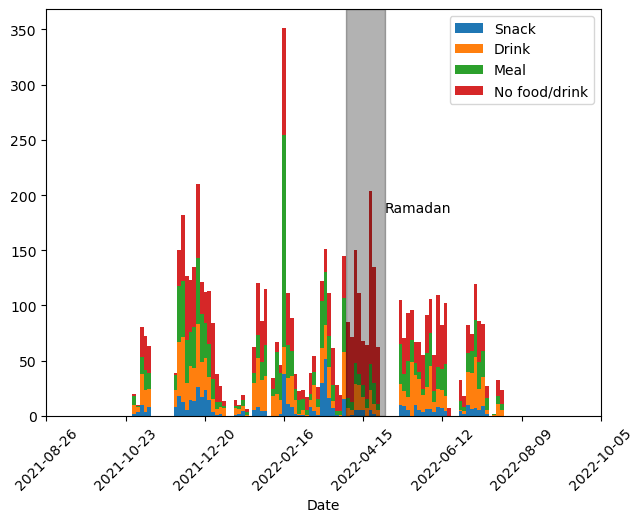

In [7]:
""" Change the x ticks to a human-readable date"""
from matplotlib.dates import DateFormatter

axes.set_xticks(
    axes.get_xticks(),
    [
        datetime.datetime.fromtimestamp(timestamp).strftime(r"%Y-%m-%d")
        for timestamp in axes.get_xticks()
    ],
    rotation=45,
)

axes.set_xlabel("Date")

plt.show()